# PUI Fall 2017 HW 6
### Yuwen Chang (ywc249)
### October 2017
### Objective: measure and predict energy use based on observables that are easily acquired; test for optimal model
### Test: how well does *energy consumed by a building* relates to the *number of units* in the building?

In [1]:
# import packages
from __future__ import print_function, division

import numpy as np
import pandas as pd
import geopandas as gp
import statsmodels.formula.api as smf
import pylab as pl
import os

from pandas.plotting import scatter_matrix as smx

%pylab inline

#import statsmodels.api as sm
#from pandas.tools.plotting import scatter_matrix

#if os.getenv("PUIDATA") is None:
#    print ("$PUIDATA to point to set PUIdata dir")

Populating the interactive namespace from numpy and matplotlib


# Download and read data (stored in PUIDATA)

In [2]:
# energy consumption data source:
# https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z
link1 = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
os.system("curl -o energy.csv " + link1)
os.system("mv energy.csv " + os.getenv("PUIDATA"))

#os.system("mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv " + os.getenv("PUIDATA"))

0

In [3]:
# pluto Manhattan data source:
# https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
link2 = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip'
os.system("curl -O " + link2)
os.system("unzip mn_mappluto_16v2.zip -d " + os.getenv("PUIDATA") + "/Manhattan")

256

In [4]:
# read data
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/energy.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

#nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

In [5]:
nrg.columns

Index(['BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [6]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

# 1. Data management

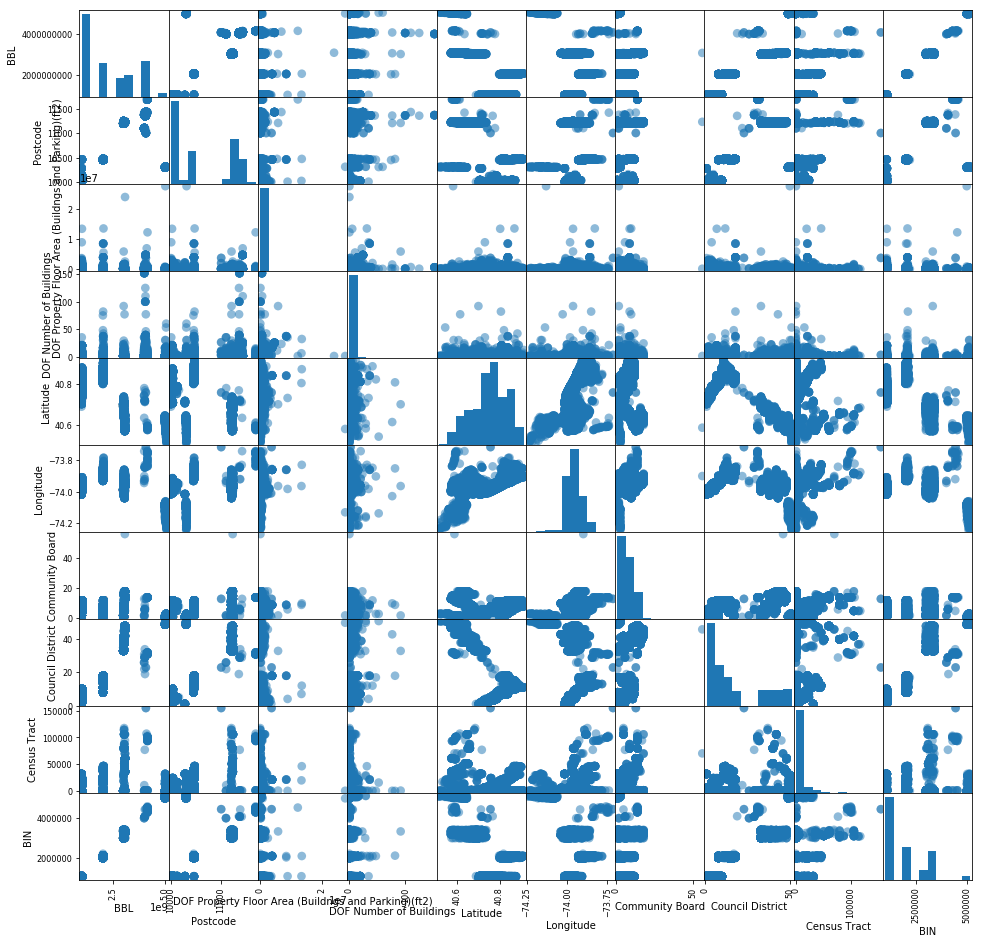

In [7]:
# examine scatter matrix
smx(nrg, s=300, figsize=(16, 16));

### Fig 1: Scatter matrix of all numerical values in the data
There are not many meaningful subplots in this matrix. Some important variables are not shown and others are not really relevant or making sense.

## 1.1 nrg data

In [8]:
# drop unnecessary columns
nrg.drop(['Co-reported BBL Status', 'BBLs Co-reported',
          'Reported NYC Building Identificaiton Numbers (BINs)',
          'Street Number', 'Street Name', 'Borough', 'Postcode',
          'DOF Benchmarking Submission Status',
          'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
          'Weather Normalized Source EUI(kBtu/ft2)',
          'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
          'Automatic Water Benchmarking Eligible', 'Reported Water Method',
          'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
          'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
          'DOF Property Floor Area (Buildngs and Parking)(ft2)',
          'Primary Property Type - Self Selected',
          'Latitude', 'Longitude', 'Community Board', 'Council District',
          'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)

In [9]:
# rename columns
nrg.rename(columns={'Site EUI(kBtu/ft2)':'EUI',
                    'Reported Property Floor Area (Building(s)) (ft²)':'fl_area',
                    'DOF Number of Buildings':'n_bldg'}, inplace=True)
nrg.head()

,BBL,EUI,fl_area,n_bldg
Record Number,,,,
12086,1.000410e+09,NaN,918919,NaN
14354,4.021460e+09,NaN,NaN,1.0
12150,2.027620e+09,NaN,64200,NaN
12590,1.006700e+09,NaN,NaN,1.0
15591,2.048300e+09,NaN,50000,NaN


In [10]:
# convert strings to numeric values
nrg['EUI'] = pd.to_numeric(nrg['EUI'], errors='coerce')
#print(nrg['EUI'].astype(float))
nrg['fl_area'] = pd.to_numeric(nrg['fl_area'], errors='coerce')
#print(nrg['fl_area'].astype(float))
nrg['n_bldg'] = pd.to_numeric(nrg['n_bldg'], errors='coerce')
#print(nrg['n_bldg'].astype(float))

## 1.2 bsize data

In [11]:
# drop unnecessary columns
bsize.drop(['APPBBL', 'APPDate', 'Address',
            'AreaSource', 'AssessLand', 'AssessTot', 'BldgArea', 'BldgClass',
            'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
            'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
            'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
            'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
            'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
            'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
            'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
            'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
            'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
            'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDistr',
            'SanitSub', 'SchoolDist', 'SPDist3', 'SplitZone', 'StrgeArea', 'TaxMap',
            'Tract2010', 'Version', 'XCoord', 'YCoord',
            'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
            'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
            'geometry'], axis=1, inplace=True)

In [12]:
# rename columns
bsize.rename(columns={'UnitsRes':'u_res',
                      'UnitsTotal':'u_total',
                      'YearBuilt':'year'}, inplace=True)
bsize.head()

,u_res,u_total,year,BBL
0,0,0,1900,1.000010e+09
1,0,0,1987,1.000090e+09
2,500,602,1902,1.000158e+09
3,0,50,1900,1.000130e+09
4,0,0,1900,1.000010e+09


In [13]:
# check that columns are numeric
bsize.u_res.astype(float)
bsize.u_total.astype(float)
bsize.year.astype(float)
bsize.BBL.astype(float)

0        1.000010e+09
1        1.000090e+09
2        1.000158e+09
3        1.000130e+09
4        1.000010e+09
5        1.000010e+09
6        1.000130e+09
7        1.000090e+09
8        1.000030e+09
9        1.000120e+09
10       1.000030e+09
11       1.000168e+09
12       1.000160e+09
13       1.000030e+09
14       1.000120e+09
15       1.000030e+09
16       1.000030e+09
17       1.000130e+09
18       1.000090e+09
19       1.000090e+09
20       1.000300e+09
21       1.000328e+09
22       1.000318e+09
23       1.000080e+09
24       1.000290e+09
25       1.000290e+09
26       1.000390e+09
27       1.000020e+09
28       1.000350e+09
29       1.000070e+09
             ...     
42656    1.008968e+09
42657    1.010778e+09
42658    1.010478e+09
42659    1.013428e+09
42660    1.014298e+09
42661    1.014738e+09
42662    1.018878e+09
42663    1.018438e+09
42664    1.016308e+09
42665    1.018318e+09
42666    1.019448e+09
42667    1.018448e+09
42668    1.019438e+09
42669    1.019448e+09
42670    1

## 1.3 Merge

In [14]:
# examine missing values
for c in nrg.columns:
    print("invalid entries in %s changed to NaN %d"%(c, sum(np.isnan(nrg.loc[:,c]).sum())))

for c in bsize.columns:
    print("invalid entries in %s changed to NaN %d"%(c, sum(np.isnan(bsize.loc[:,c]).sum())))

invalid entries in BBL changed to NaN 156
invalid entries in EUI changed to NaN 4623
invalid entries in fl_area changed to NaN 3125
invalid entries in n_bldg changed to NaN 1705
invalid entries in u_res changed to NaN 0
invalid entries in u_total changed to NaN 0
invalid entries in year changed to NaN 0
invalid entries in BBL changed to NaN 0


In [15]:
# check data type
type(bsize.BBL.values[0]), type(nrg.BBL.values[0])

#(bsize.BBL.values[0]), (nrg.BBL.values[0])

(numpy.float64, numpy.float64)

In [16]:
# merge
data = pd.merge(nrg, bsize, on='BBL').dropna()
data.shape

(4688, 7)

In [17]:
data.head()

,BBL,EUI,fl_area,n_bldg,u_res,u_total,year
2,1.013110e+09,125.4,330000.0,1.0,0,56,1977
15,1.007660e+09,122.3,59468.0,1.0,0,8,1912
16,1.008150e+09,117.0,364000.0,1.0,0,24,1954
18,1.005050e+09,82.1,235370.0,1.0,0,24,1926
19,1.021420e+09,137.7,64806.0,1.0,54,62,1924


# 2. Exploratory analysis

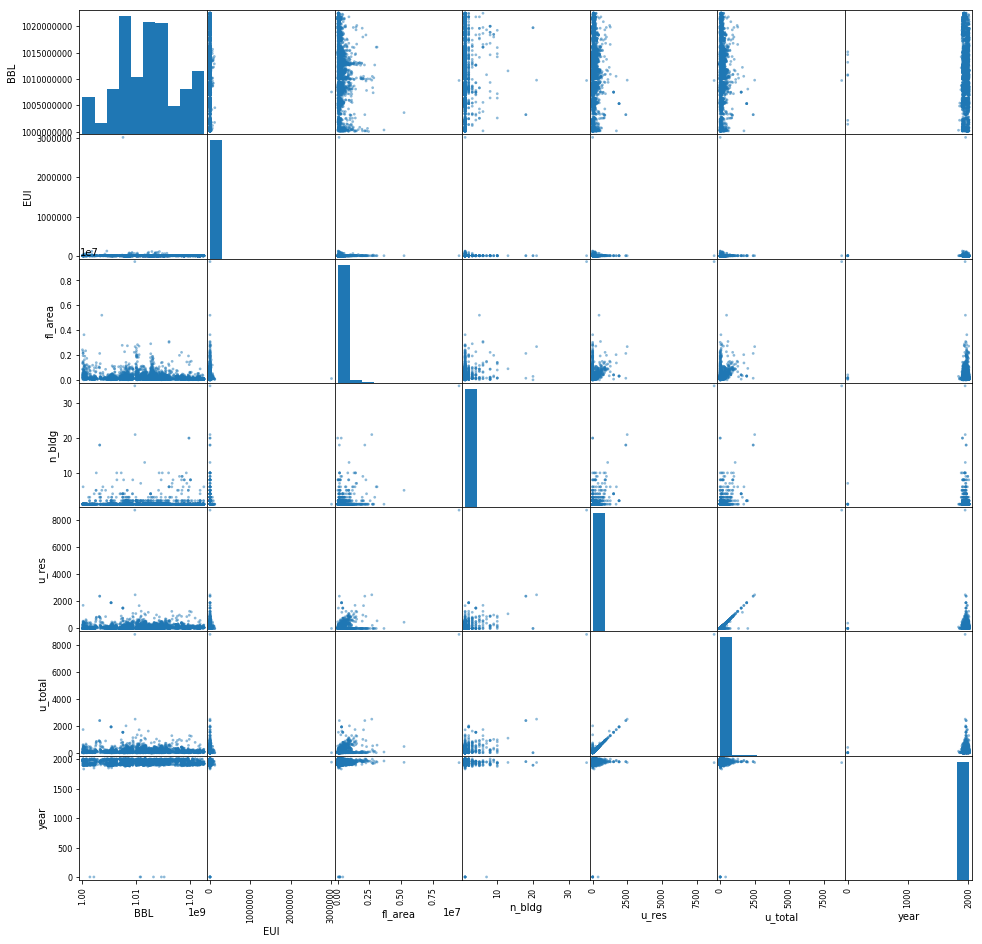

In [18]:
# examine scatter matrix
smx(data, s=30, figsize=(16, 16));

### Figure 2: scatter matrix of final data set
Some variables have highly correlated by nature, such as total units and residential units.

Other correlations remain rather unobvious mainly due to scale problem.

In [19]:
# create a variable for total energy consumption of buildings
data['EUI_total'] = data.EUI * data.fl_area

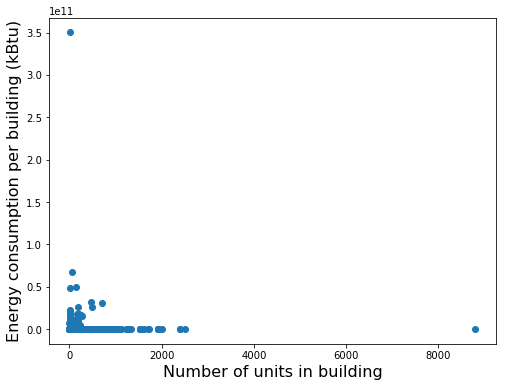

In [20]:
# plot scatter plot
pl.figure(figsize=(8,6))
pl.scatter(data.u_total, data.EUI_total)
pl.xlabel('Number of units in building', fontsize=16)
pl.ylabel('Energy consumption per building (kBtu)', fontsize=16)

### Figure 3. Scatter plot of total energy consumption over units in a building
No clear relationship due to outliers stretching out the range of the plot.

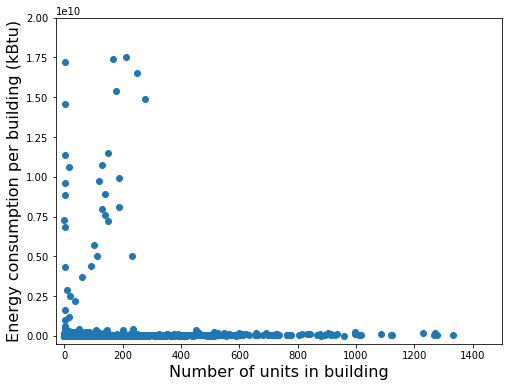

In [21]:
# re-plot with axis limits
pl.figure(figsize=(8,6))
pl.scatter(data.u_total, data.EUI_total)
pl.xlabel('Number of units in building', fontsize=16)
pl.ylabel('Energy consumption per building (kBtu)', fontsize=16)
pl.xlim(-30, 1500)
pl.ylim(-5e8, 2e10);

### Figure 4. Scatter plot of total energy consumption over units in a building (cut-range)
After we cut off the outlier, we still don't see obvious relations.

In [22]:
# cut data to a reasonable range
data_cut = data[(data.EUI_total>1000) & (data.u_total>=10) & (data.u_total<1000)]

#data.drop(data.index[data.u_total == 0], axis=0, inplace=True)

### Note
Units above 1,000 are also cut from the data at this point to develop a model for the majority of buildings without being affected by few but potentially highly influential cases.

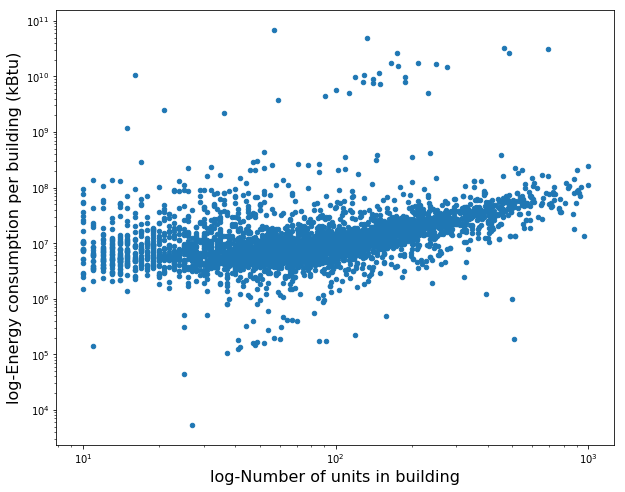

In [23]:
# re-plot both variables in a log scale
ax = data_cut.plot(kind='scatter', y='EUI_total', x='u_total',
                   marker='o', figsize=(10, 8), loglog=True)
ax.set_xlabel('log-Number of units in building', fontsize=16)
ax.set_ylabel('log-Energy consumption per building (kBtu)', fontsize=16)

#pl.loglog(data.u_total, data.EUI_total, '.')

### Figure 5. Scatter plot of total energy consumption over units in a building (log-log transformed)
Finally, we can now observe a positive relation between building units and energy consumption after log-transformed both variables.

# 3. Explanatory analysis
## DV: total energy consumption per building (kBtu)
## IV: total units in building

## 3.1 Units vs Energy OLS

In [24]:
# fit model
lm0 = smf.ols(formula='np.log10(u_total) ~ np.log10(EUI_total)', data=data_cut, missing='drop').fit()
lm0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log10(u_total)   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     800.6
Date:                Sat, 21 Oct 2017   Prob (F-statistic):          1.13e-160
Time:                        01:03:58   Log-Likelihood:                -1594.5
No. Observations:                3992   AIC:                             3193.
Df Residuals:                    3990   BIC:                             3206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.5032      0.085     -5.929      0.000      -0.670      -0.337
np.log10(EUI_total)     0.3405      0.012     28.295      0.000       0.317       0.364
==============================================================================
Omnibus:                      153.836   Durbin-Watson:                   1.356
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.715
Skew:                          -0.488   Prob(JB):                     5.16e-38
Kurtosis:                       3.280   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

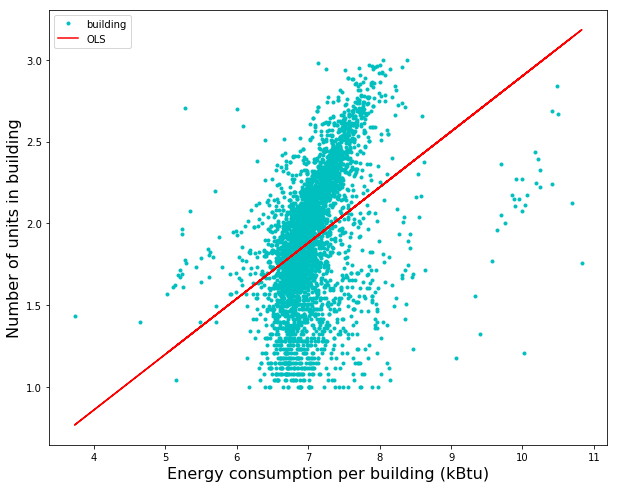

In [25]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(data_cut.EUI_total), np.log10(data_cut.u_total), 'c.', label='building')
pl.plot(np.log10(data_cut.EUI_total), lm0.fittedvalues, 'r-', label='OLS')
pl.xlabel('Energy consumption per building (kBtu)', fontsize=16)
pl.ylabel('Number of units in building', fontsize=16)
pl.legend();

### Figure 6. Scatter plot of total energy consumption over units in a building (log-log transformed)
This is not a very good fitting. In the plot, energy consumption is rather concentrated for most buildings of all size of units with little variation, while the spreadout on both tails are dragging the model to both sides. By logic, it makes more sense to predict energy consumption based on units, which is an indicator for occupants.

## 3.2 Energy vs Units OLS (linear model)

In [26]:
# fit model
lm = smf.ols(formula='np.log10(EUI_total) ~ np.log10(u_total)', data=data_cut, missing='drop').fit()
lm.summary()

#X = sm.add_constant(np.log10(x))
#linmodel = sm.OLS(np.log10(y), X, missing='drop').fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log10(EUI_total)   R-squared:                       0.167
Model:                             OLS   Adj. R-squared:                  0.167
Method:                  Least Squares   F-statistic:                     800.6
Date:                 Sat, 21 Oct 2017   Prob (F-statistic):          1.13e-160
Time:                         01:03:58   Log-Likelihood:                -2324.2
No. Observations:                 3992   AIC:                             4652.
Df Residuals:                     3990   BIC:                             4665.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.1076      0.034    182.100      0.000       6.042       6.173
np.log10(u_total)     0.4908      0.017     28.295      0.000       0.457       0.525
==============================================================================
Omnibus:                     2192.819   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48020.607
Skew:                           2.155   Prob(JB):                         0.00
Kurtosis:                      19.436   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

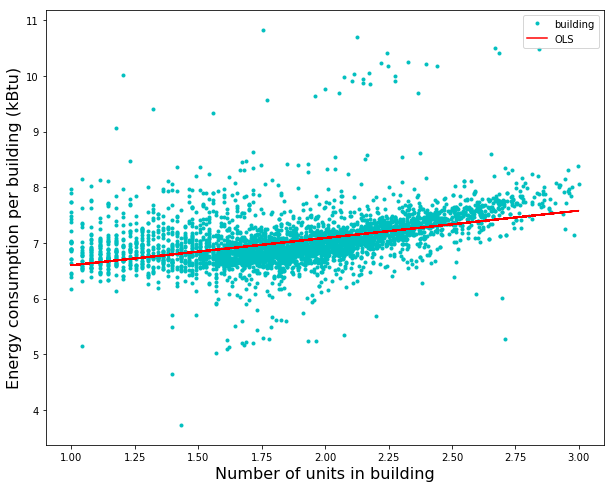

In [27]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(data_cut.u_total), np.log10(data_cut.EUI_total), 'c.', label='building')
pl.plot(np.log10(data_cut.u_total), lm.fittedvalues, 'r-', label='OLS')
pl.xlabel('Number of units in building', fontsize=16)
pl.ylabel('Energy consumption per building (kBtu)', fontsize=16)
pl.legend();

### Figure 7. Scatter plot of total energy consumption over units in a building (log-log transformed)
The model seems to capture the upward tendency of energy consumption as units increase.

### Summary
- As discussed, energy consumption is a more logical DV with units inbuilding as the IV.
- For the latter model, every percent increase in numbers of unit in a building is predicting a half percent increase in average in total energy consumption in the building.
- We may do a chi-square test to compare the two models.

## 3.3 Evaluate models by calculating the $\chi^2$
    
$\chi^2 = \sum_i \frac{(model(x_i) - data(x_i))^2}{error_i^2}$
    
$error_i = \sqrt{data(x_i)}$

In [28]:
# define function for chi-square statistic
def chi2(data, model, errors=None):
    '''Calculates the chi-sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: series of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return(((data - model)**2) / errors**2).sum()
    else: 
        print('ERROR: must pass arrays of identical dimension for data, model and (optional) error)')
        return(-1)

## 3.4 Calculate errors for $\chi^2$ calculation
Assume Poisson statistics for the errors on the independent variable.

# EXPLAIN THE FORMULA

$f = a\log_{10}(A)$

$\sigma_{f} \approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [29]:
# calculate errors of EUI
err_EUI = np.sqrt((data_cut['fl_area'])**2 + (data_cut['EUI']**2)) # error of EUI_total

# calculate errors of units
err_u = np.sqrt(data_cut.u_total) # error of u_total

In [30]:
# calculate errors in terms of log transformation
err_logEUI = np.abs(err_EUI / data_cut.EUI_total / np.log(10))
err_logu = np.abs(err_u / data_cut.u_total / np.log(10))

data_cut['err_EUI'] = err_logEUI
data_cut['err_u'] = err_logu

/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
# calculate chi-square statistic
print(chi2(np.log10(data_cut.EUI_total), lm0.fittedvalues, data_cut.err_EUI))
print(chi2(np.log10(data_cut.EUI_total), lm.fittedvalues, data_cut.err_EUI))

20399957099510.68
3429375307682.7046


### Summary
We are not able to do a likelihood ratio test on the two model because they are not nested. To perform a likelihood ratio test, one of the models is often restricted by having $k$ parameters set to zero, which form the hypothesized reduced model, then we may test whether or not the reduced model is nested in the current (more complex) model.

## 3.5 Quadratic Energy vs Units OLS (curve model)

In [32]:
# fit model
cm = smf.ols(formula='np.log10(EUI_total) ~ np.log10(u_total) + I(np.log10(u_total)**2)', data=data_cut, missing='drop').fit()
cm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log10(EUI_total)   R-squared:                       0.232
Model:                             OLS   Adj. R-squared:                  0.232
Method:                  Least Squares   F-statistic:                     603.4
Date:                 Sat, 21 Oct 2017   Prob (F-statistic):          1.12e-229
Time:                         01:03:59   Log-Likelihood:                -2161.6
No. Observations:                 3992   AIC:                             4329.
Df Residuals:                     3989   BIC:                             4348.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     8.1337      0.115     70.892      0.000       7.909       8.359
np.log10(u_total)            -1.7302      0.122    -14.198      0.000      -1.969      -1.491
I(np.log10(u_total) ** 2)     0.5824      0.032     18.399      0.000       0.520       0.645
==============================================================================
Omnibus:                     2363.734   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65676.793
Skew:                           2.316   Prob(JB):                         0.00
Kurtosis:                      22.323   Cond. No.                         118.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

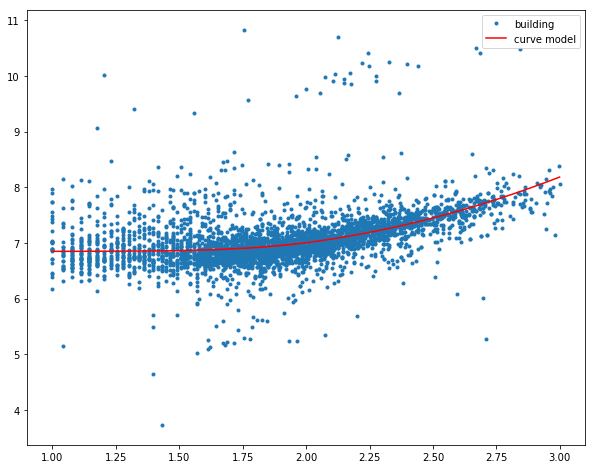

In [33]:
# plot
pl.figure(figsize=(10,8))
pl.plot(np.log10(data_cut.u_total), np.log10(data_cut.EUI_total), '.', label='building')
pl.plot(np.log10(data_cut.u_total).sort_values(), cm.fittedvalues.sort_values(), 'r-',
        markersize=4, label='curve model')
pl.legend();

### Figure 8. Scatter plot of total energy consumption over units in a building (log-log transformed)
The quadratic model fit even closer to the observations as it has more degree of freedom.

## 3.6 Compare linear and quadratic models with Likelihood-ratio test
$H_0:$ The restricted (simpler) model, linear model (lm), is nested in the more complex curve model (cm); in other words, the reduced model is true.

In [34]:
# conduct Likelihood-ratio test
print ("LR statistic: ", -2 * (lm.llf - cm.llf))
print ("LR statistic from statsmodels: ", cm.compare_lr_test(lm)[0])

cm.compare_lr_test(lm)

LR statistic:  325.157988067
LR statistic from statsmodels:  325.157988067


(325.15798806713792, 1.0899519200204675e-72, 1.0)

### Result: We reject $H_0$ at $\alpha = 0.05$ *linear model* is not preferable to *curve model*.
Because the LR statistics $325.16$ has exceeded the threshold of $\chi_1^{0.05} = 3.84$.

# Extra credit 1: calculate and plot the likelihood surface

In [35]:
# define residual calculation function
def residuals(intercept, slope, data, errors=None):
    """
    Purpose: calculate residuals for a given intercept and slope
    Args:
        intercept: intercept of a model
        slope: slope of a model
        data: data that contains X, Y columns
        errors: error term of Y, default is None
    Return: sum of residuals at a given intercept and slope
    """
    return((np.log(data.EUI_total) - np.log(data.u_total) * slope + intercept )**2 / errors**2).sum()

In [36]:
# set up variables
a = lm.params[0] # intercept
b = lm.params[1] # slope

A = np.arange(-100, 100, 1)      # intercept
B = np.arange(-50.0, 50.0, 0.5)  # slope

In [37]:
# fill in numbers (residuals) for the surface
Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a, b, data_cut, err_EUI))

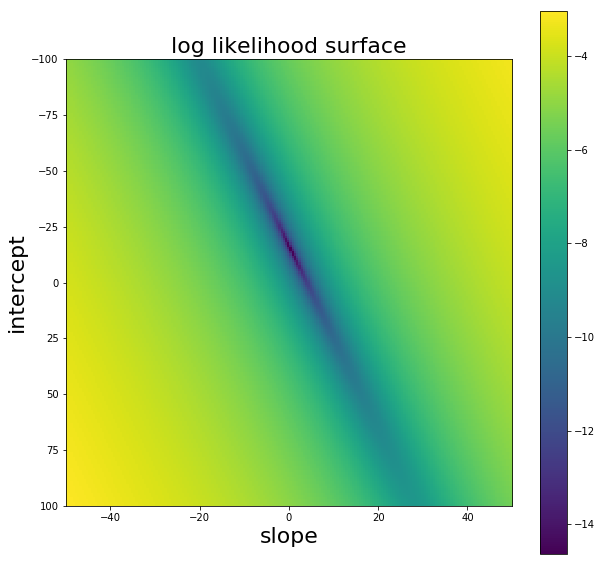

In [38]:
# plot the surface
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize=22)
pl.imshow(np.log(Lsurface), extent=[-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize=22)
pl.ylabel('intercept', fontsize=22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)